##Importing and Visualization of the Dataset

Importing the dataset

Understanding LSTM and paramenters : https://colab.research.google.com/github/kmkarakaya/ML_tutorials/blob/master/LSTM_Understanding_the_Number_of_Parameters.ipynb#scrollTo=BfQeJ0TLhXSg

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Activation,Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline

Downloading the dataset

In [2]:
url = 'https://raw.githubusercontent.com/SamratDuttaOfficial/DelhiPollutionLSTM/master/DelhiPollutionData.csv'
df = pd.read_csv(url)

# original dataset link: https://app.cpcbccr.com/ccr/#/caaqm-dashboard-all/caaqm-landing
# Location: CRRI Mathura Road, Delhi - IMD
# PM2.5,PM10
# 24 Hours average
# From: 01-01-2018 T00:00:00Z 00:00
# To: 31-03-2021 T14:47:59Z 00:00

Data cleaning

In [3]:
for i in range(0, len(df['Date'])):
  df["Date"][i] = df["Date"][i][0:10]
df = df.set_index("Date")

In [4]:
df['PM2_5'] = pd.to_numeric(df['PM2_5'],errors='coerce')
df['PM10'] = pd.to_numeric(df['PM10'],errors='coerce')

Dataset table

In [5]:
df

,PM2_5,PM10
Date,,
01-01-2018,156.25,520.27
02-01-2018,206.58,630.55
03-01-2018,131.16,366.86
04-01-2018,223.67,323.72
05-01-2018,224.11,330.63
...,...,...
27-03-2021,88.55,244.84
28-03-2021,104.95,259.30
29-03-2021,95.70,215.49


Visualization of the dataset

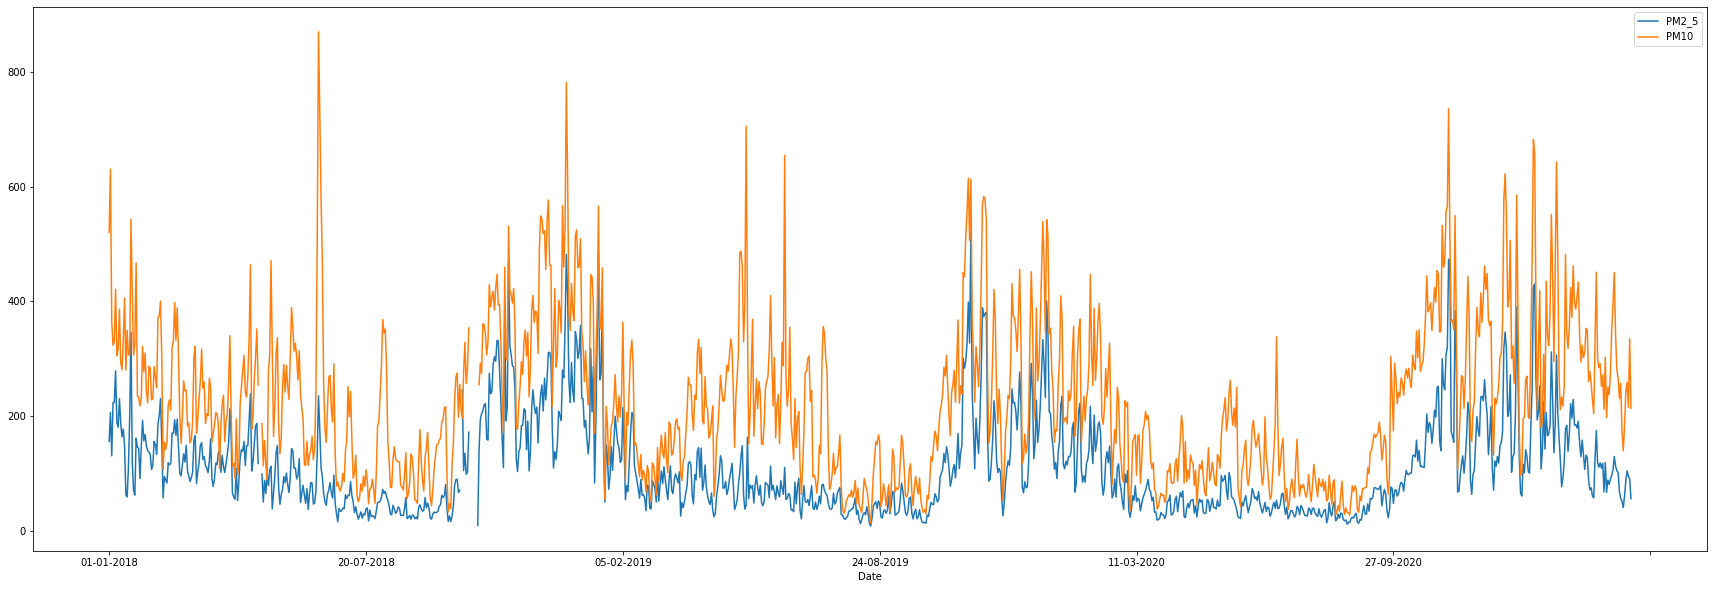

In [6]:
df.plot(figsize=(30, 10))

Smoothening using Exponential moving average technique

In [8]:
df_smooth = df.copy()

In [9]:
df_smooth['PM2_5'] = df_smooth['PM2_5'].ewm(span=20).mean()
df_smooth['PM10'] = df_smooth['PM10'].ewm(span=20).mean()

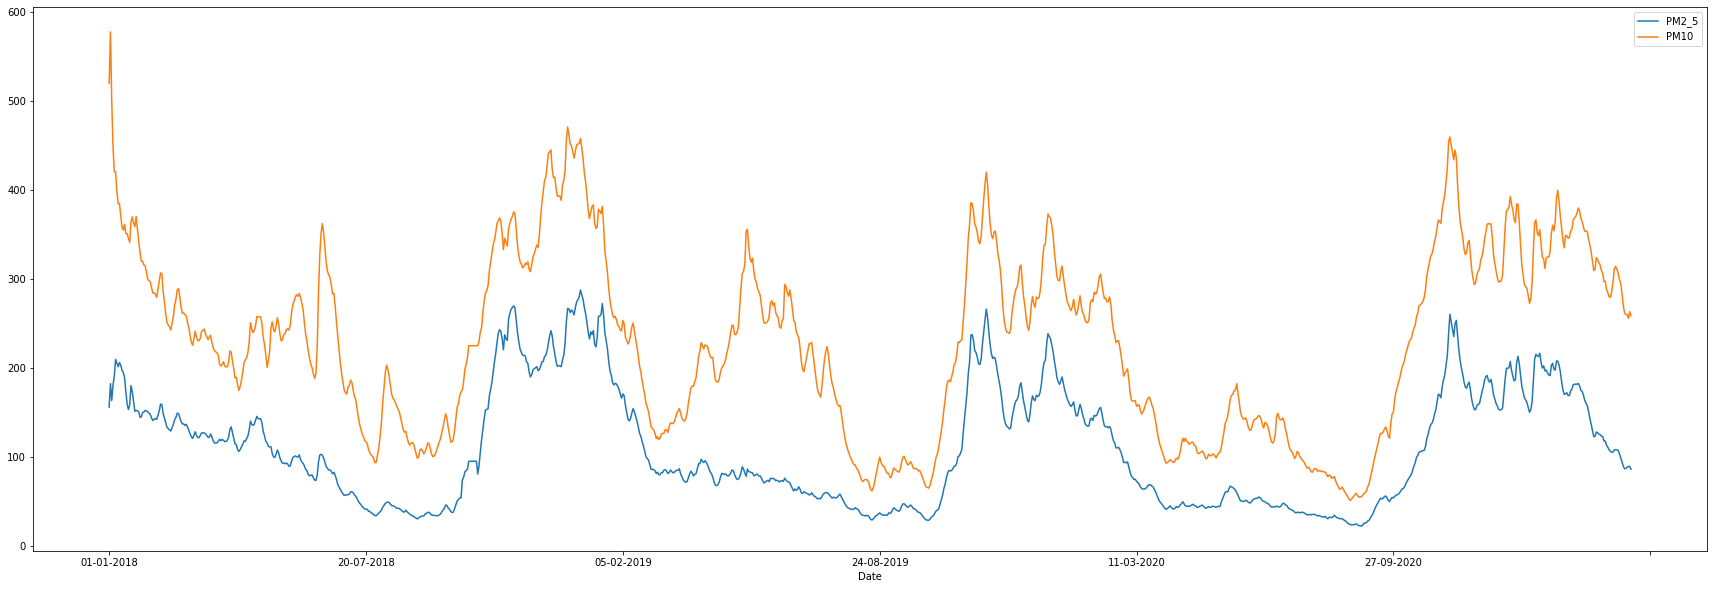

In [10]:
df_smooth.plot(figsize=(30, 10))

#### For PM2.5 data

Data processing (building time-series training dataset)

In [11]:
day = 365 # Number of days (Window size of time-series data)

In [12]:
k = 0

array = []
array_temp = []
train_data = []
train_labels = []

for i in range(len(df_smooth)):
    array_temp.append(df_smooth.iloc[i]['PM2_5'])

array_temp = np.array(array_temp).reshape(-1,1)
# suppose, the array was like [1, 2, 3, 4] then reshape makes it like [[1], [2], [3], [4]].
scaler = MinMaxScaler()
array_temp = scaler.fit_transform(array_temp)
# Making all values in the range of 0 to 1
array_temp = array_temp.tolist()
# converting the numpy array to list
# print(array_temp)

for i in array_temp:
    array.append(i[0])

for i in range(len(array)):
    try:
        #train_data.append(array[day*k:day*(k+1)]) # dividing the dataset into 'day' days of data
        #train_labels.append([array[day*(k+1)]])
        train_data.append(array[k:day+k]) # Creating inner lists with 'day' days of data
        train_labels.append([array[day+k]])
        k+=1
    except:
        break

#train_data = np.squeeze(train_data)
train_data = np.array(train_data)
train_labels = np.array(train_labels)

In [13]:
print(train_data.shape)
print(train_labels.shape)

(822, 365)
(821, 1)


In [14]:
train_data = train_data[:len(train_labels)]
train_data = np.expand_dims(train_data,1)
train_data.shape

(821, 1, 365)

In [15]:
#train_data[1]

In [16]:
train_labels[1]

array([0.97205407])

Building the machine learning model

In [17]:
model = Sequential()

model.add(LSTM(250,input_shape=(1,day)))
model.add(Dropout(0.5))

model.add(Dense(500,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(250,input_shape=(1,day)))
model.add(Dropout(0.5))

model.add(Dense(day,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='relu'))

model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 250)               616000    
                                                                 
 dropout (Dropout)           (None, 250)               0         
                                                                 
 dense (Dense)               (None, 500)               125500    
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 250)               125250    
                                                                 
 dropout_2 (Dropout)         (None, 250)               0         
                                                                 
 dense_2 (Dense)             (None, 365)               9

Training the machine learning model

In [18]:
E = 1000
callback = EarlyStopping(monitor='loss', mode='min', patience=20)
H = model.fit(train_data,train_labels,epochs=E, verbose=0, callbacks=[callback])

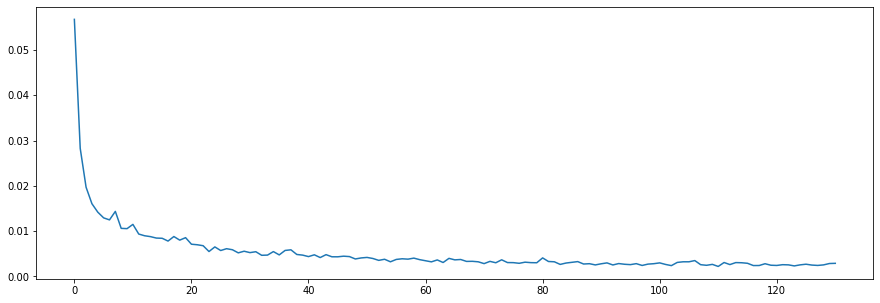

In [19]:
loss = H.history['loss']
epochs = range(0,len(loss))
plt.figure(figsize=(15,5))
plt.plot(epochs,loss)

Forecasting existing data

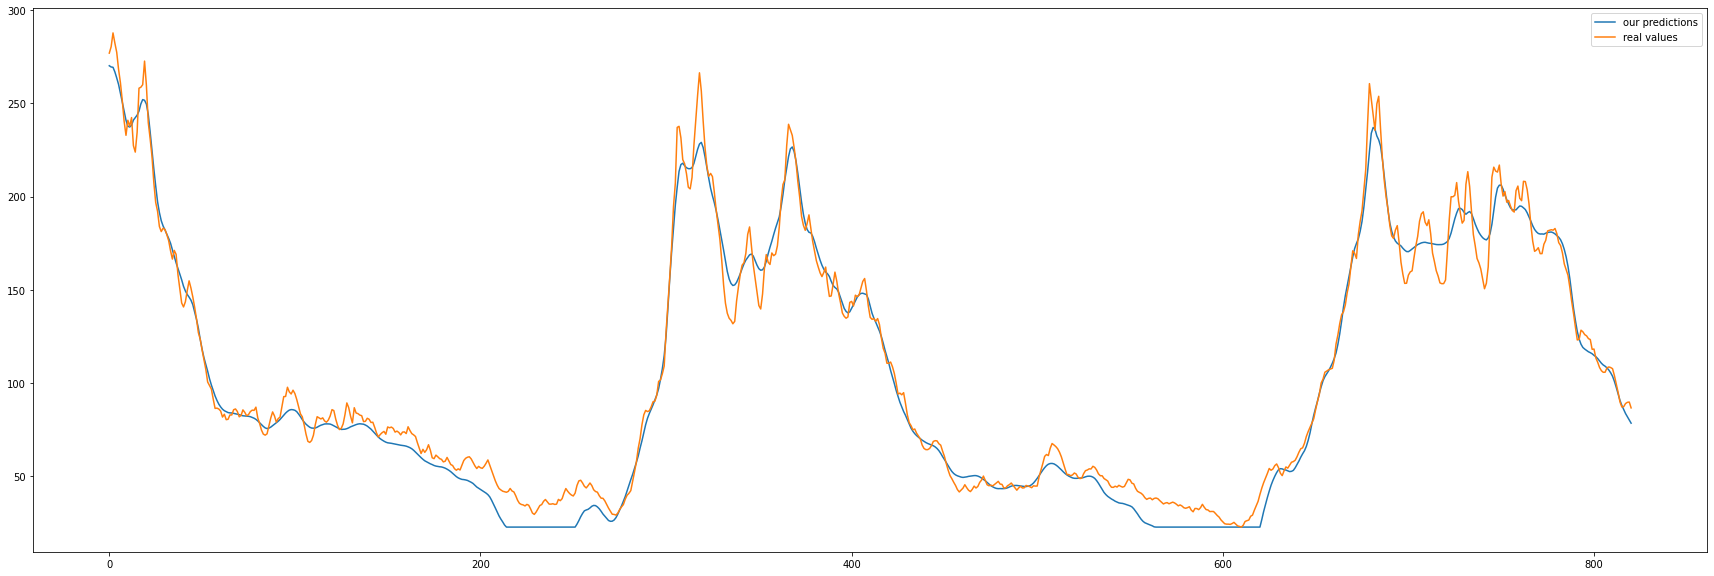

In [20]:
preds = scaler.inverse_transform(model.predict(train_data))
plt.figure(figsize=(30,10))
plt.plot(preds,label='our predictions')
plt.plot(scaler.inverse_transform(train_labels),label='real values')
plt.legend()

Forecasting fututre data

In [21]:
days_to_predict = 300
seed = array[-day:]

In [22]:
for _ in range(days_to_predict):
    current_days = seed[-day:]
    current_days = np.squeeze(current_days)
    current_days = np.expand_dims(current_days,0)
    current_days = np.expand_dims(current_days,0)
    pred = model.predict(current_days)
    seed = np.append(seed,pred)


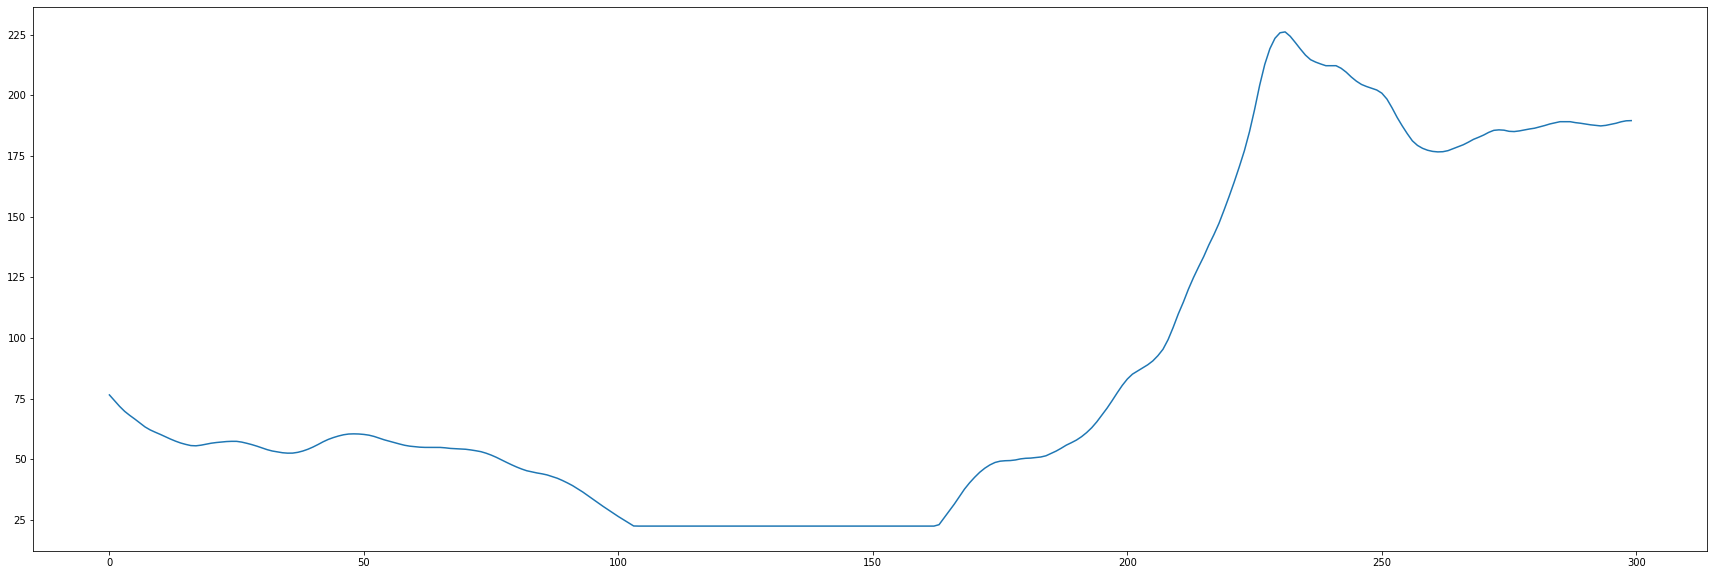

In [23]:
upcoming_days_prediction = scaler.inverse_transform(seed[-days_to_predict:].reshape(-1,1))
plt.figure(figsize=(30,10))
plt.plot(range(0,days_to_predict),upcoming_days_prediction)

In [24]:
# Adding real values and predicted values together
arr_without_pred = scaler.inverse_transform(train_labels)
arr_pred = scaler.inverse_transform(seed[-days_to_predict:].reshape(-1,1))
arr_with_pred = np.concatenate((arr_without_pred, arr_pred))

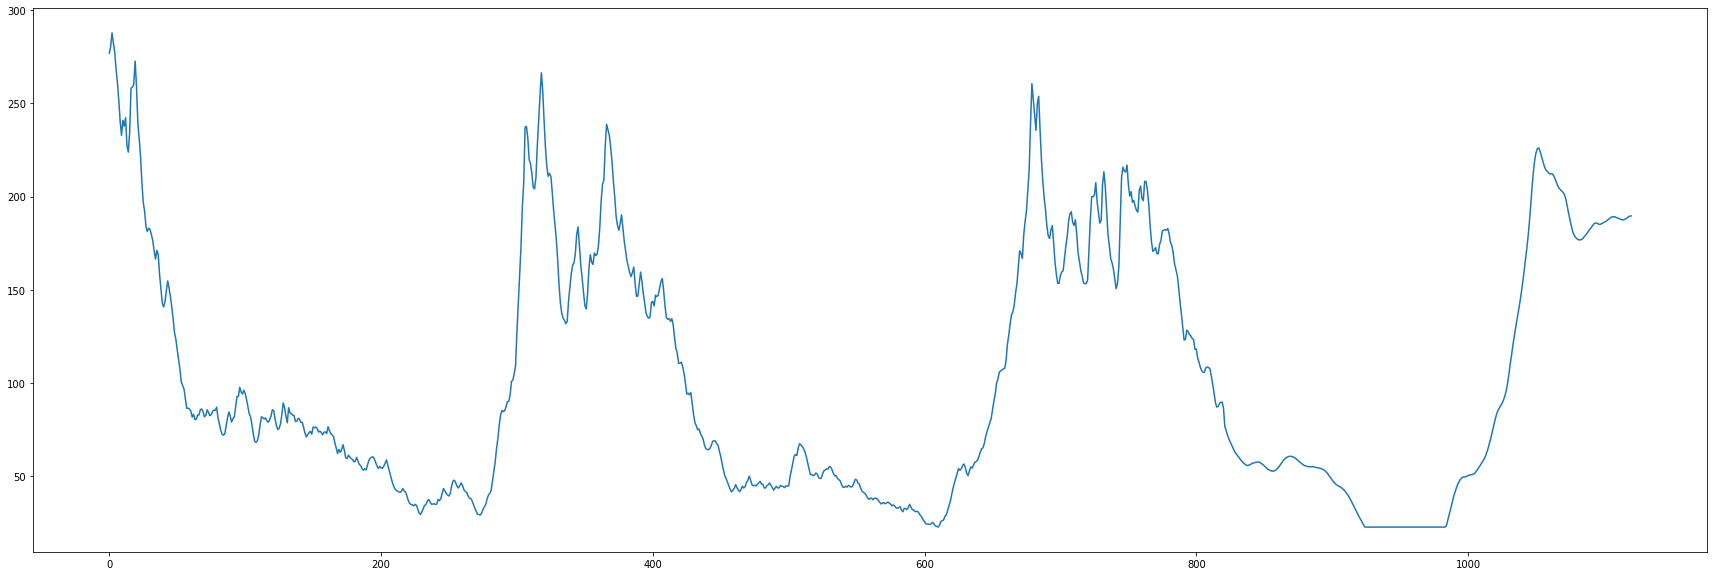

In [25]:
plt.figure(figsize=(30,10))
plt.plot(arr_with_pred)

#### For PM10 data

Data processing (building time-series training dataset)

In [26]:
k2 = 0

array2 = []
array_temp2 = []
train_data2 = []
train_labels2 = []

for i in range(len(df_smooth)):
    array_temp2.append(df_smooth.iloc[i]['PM10'])

array_temp2 = np.array(array_temp2).reshape(-1,1)
scaler = MinMaxScaler()
array_temp2 = scaler.fit_transform(array_temp2)
array_temp2 = array_temp2.tolist()
for i in array_temp2:
    array2.append(i[0])

for i in range(len(array2)):
    try:
        #train_data.append(array[day*k:day*(k+1)]) # dividing the dataset into 'day' days of data
        #train_labels.append([array[day*(k+1)]])
        train_data2.append(array2[k2:day+k2]) # Creating inner lists with 'day' days of data
        train_labels2.append([array2[day+k2]])
        k2+=1
    except:
        break

#train_data = np.squeeze(train_data)
train_data2 = np.array(train_data2)
train_labels2 = np.array(train_labels2)



In [27]:
print(train_data2.shape)
print(train_labels2.shape)

(822, 365)
(821, 1)


In [28]:
train_data2 = train_data2[:len(train_labels2)]
train_data2 = np.expand_dims(train_data2,1)
train_data2.shape

(821, 1, 365)

In [29]:
train_labels2[1]

array([0.76227621])

Building the machine learning model

In [30]:
model2 = Sequential()

model2.add(LSTM(250,input_shape=(1,day)))
model2.add(Dropout(0.5))

model2.add(Dense(500,activation='relu'))
model2.add(Dropout(0.5))

model2.add(Dense(250,activation='relu'))
model2.add(Dropout(0.5))

model2.add(Dense(day,activation='relu'))
model2.add(Dropout(0.5))

model2.add(Dense(1,activation='relu'))

model2.compile(loss='mean_squared_error',optimizer='adam')

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 250)               616000    
                                                                 
 dropout_4 (Dropout)         (None, 250)               0         
                                                                 
 dense_4 (Dense)             (None, 500)               125500    
                                                                 
 dropout_5 (Dropout)         (None, 500)               0         
                                                                 
 dense_5 (Dense)             (None, 250)               125250    
                                                                 
 dropout_6 (Dropout)         (None, 250)               0         
                                                                 
 dense_6 (Dense)             (None, 365)              

Training the machine learning model

In [31]:
E2 = 1000
callback2 = EarlyStopping(monitor='loss', mode='min', patience=20)
H2 = model2.fit(train_data2,train_labels2,epochs=E, verbose=0, callbacks=[callback2])

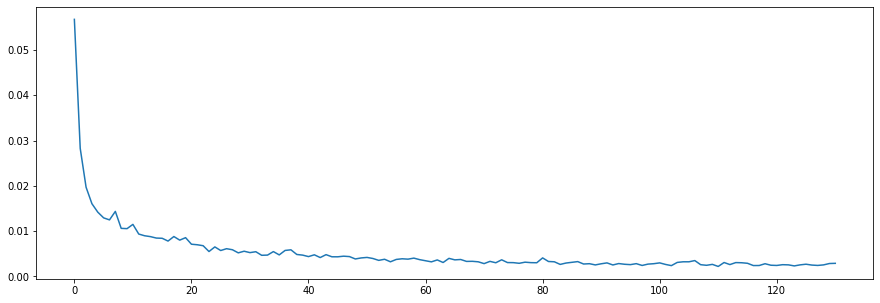

In [32]:
loss2 = H.history['loss']
epochs2 = range(0,len(loss))
plt.figure(figsize=(15,5))
plt.plot(epochs2,loss2)

Forecasting on existing data

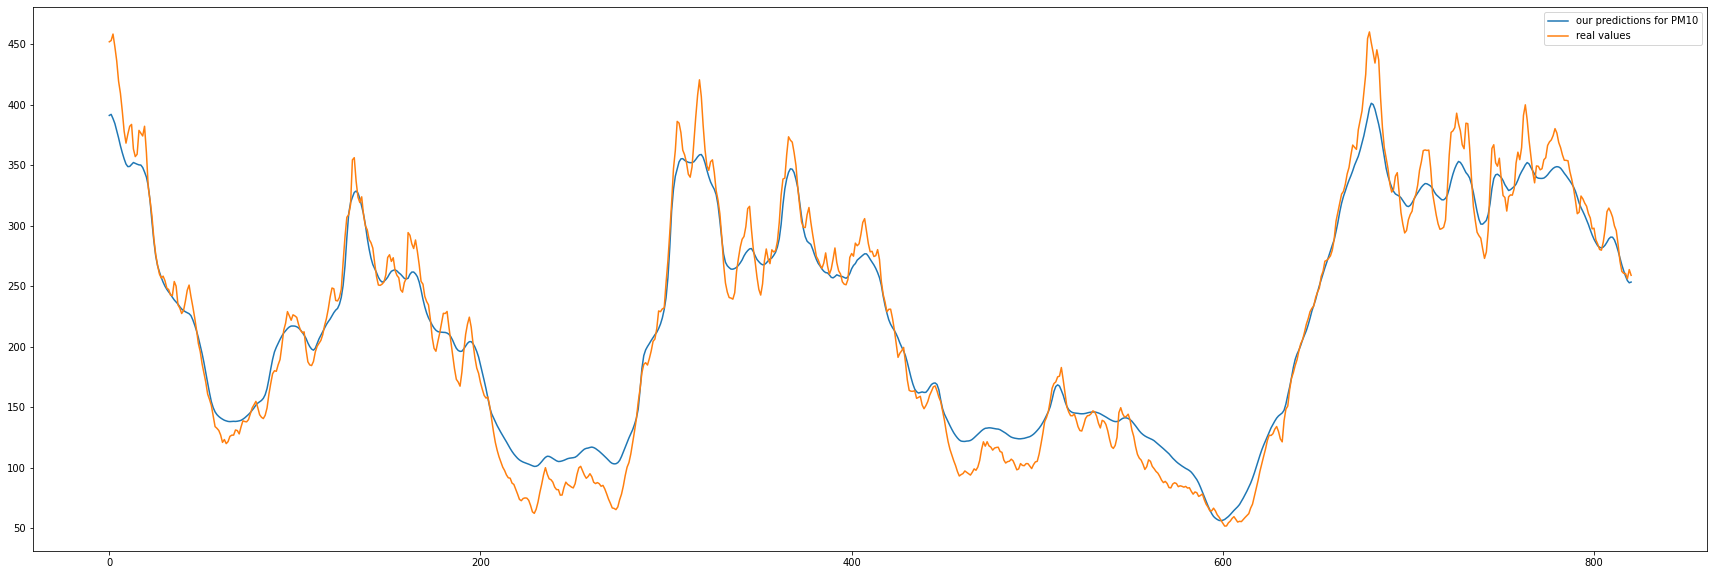

In [33]:
preds2 = scaler.inverse_transform(model2.predict(train_data2))
plt.figure(figsize=(30,10))
plt.plot(preds2,label='our predictions for PM10')
plt.plot(scaler.inverse_transform(train_labels2),label='real values')
plt.legend()

Forecasting future data (300 days)

In [37]:
days_to_predict2 = 300
seed2 = array2[-day:]

In [39]:
for _ in range(days_to_predict2):
    current_days = seed2[-day:]
    current_days = np.squeeze(current_days)
    current_days = np.expand_dims(current_days,0)
    current_days = np.expand_dims(current_days,0)
    pred2 = model2.predict(current_days)
    seed2 = np.append(seed2,pred2)

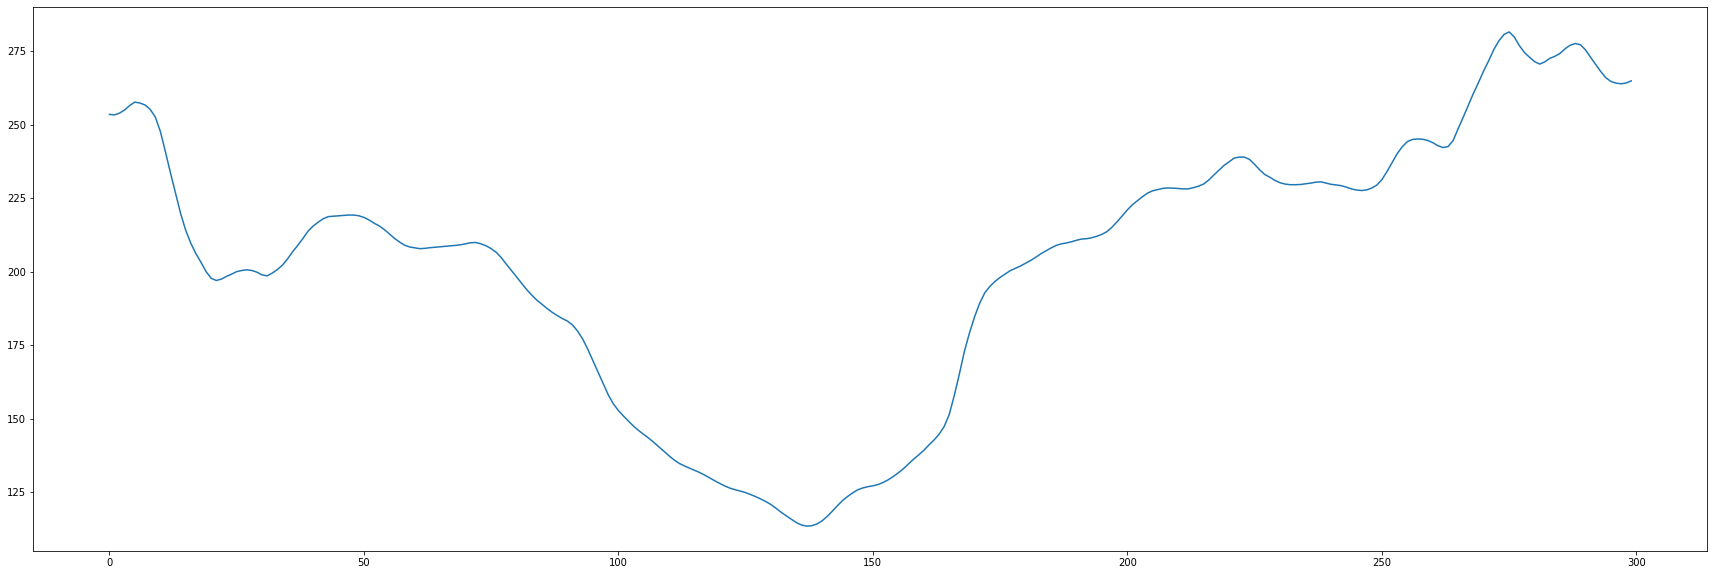

In [41]:
upcoming_days_prediction2 = scaler.inverse_transform(seed2[-days_to_predict2:].reshape(-1,1))
plt.figure(figsize=(30,10))
plt.plot(range(0,days_to_predict2),upcoming_days_prediction2)

In [42]:
# Adding real values and predicted values together
arr_without_pred2 = scaler.inverse_transform(train_labels2)
arr_pred2 = scaler.inverse_transform(seed2[-days_to_predict2:].reshape(-1,1))
arr_with_pred2 = np.concatenate((arr_without_pred2, arr_pred2))

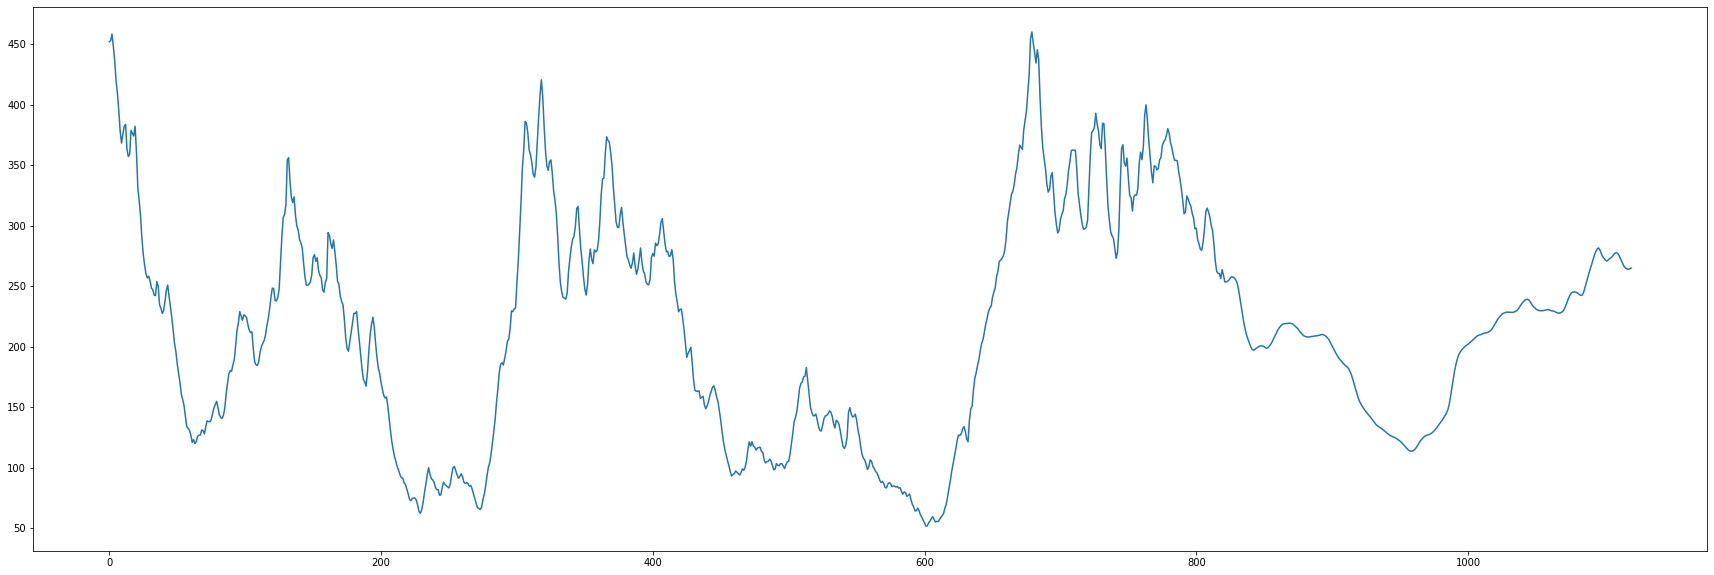

In [43]:
plt.figure(figsize=(30,10))
plt.plot(arr_with_pred2)